### Parseia IDs de usuários beta e prepara consumo do MixPanel

In [ ]:
import csv
import pdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import requests
from requests.auth import HTTPBasicAuth
import json
import math
import numpy as np
import ahpy

api_url = "https://data.mixpanel.com/api/2.0/export"
api_secret = None

def parse_api_data(http_response):
  data = http_response.text.splitlines()
  records = [json.loads(rec) for rec in data]
  
  return records

def request_events(
    from_date="2024-01-01", 
    to_date="2024-01-01", 
    events=[], 
    where='', 
    limit=None
):
    response = requests.post(
        api_url, 
        data={
            "from_date": from_date,
            "to_date": to_date,
            "event": json.dumps(events),
            "where": where,
            "limit": limit,
        },
        auth=HTTPBasicAuth(api_secret,'')
    )
    return response

def get_events_from_file(file_name):
    with open(file_name, "r") as file:
        events_list = json.load(file)

    return events_list

def get_beta_testers_ids():
    users_ids = []
    file_name = "beta_testers_ids.private.txt" if api_secret else "beta_testers_ids.masked.txt"

    with open(file_name, mode='r') as file:
        reader = csv.reader(file)
        for row in reader:
            users_ids.append(row[0])

    return users_ids

# only necessary in this case because the event being analyzed do not have information
# about the user organization, in the future we can simply add a property informing the org id
beta_testers_ids = get_beta_testers_ids()

print("número de usuários betas salvos", len(beta_testers_ids))### Parseia IDs de usuários beta e prepara consumo do MixPanelfilters_results = parse_api_data(

número de usuários betas salvos 79193


### Consumo da API do Mixpanel

Buscando por eventos de filtros e criação de atividades no período

In [47]:
filters_results = parse_api_data(
    request_events(
        from_date="2024-11-05",
        to_date="2024-11-18",
        events=["Activity Exercise Bank - Filtered Exercises"],
    )
) if api_secret else get_events_from_file("filters_events_experiment.masked.json")
hw_results = parse_api_data(
    request_events(
        from_date="2024-11-05",
        to_date="2024-11-18",
        events=["Homework Scheduled"],
    )
) if api_secret else get_events_from_file("homework_events_experiment.masked.json")

print("Nº de eventos de filtragem:", len(filters_results))
print("Nº de eventos de criação de atividades:", len(hw_results))

Nº de eventos de filtragem: 80198
Nº de eventos de criação de atividades: 30731


### Parseando eventos

Salvando valores das métricas de interesse para cada usuário único

In [48]:
unique_user_ids_found = set();

final_metrics_for_each_user = {
    "treatment": {},
    "control": {},
}

# Guarda o número de vezes que cada usuário utilizou
# o filtro de nível de dificuldade
for event in filters_results:
    user_id = event["properties"].get("$user_id")

    if not user_id:
        continue

    unique_user_ids_found.add(user_id)

    group = "treatment" if user_id in beta_testers_ids else "control"
    user_metrics = final_metrics_for_each_user[group].get(user_id)

    if event["properties"]["Used Filter"] != "Nível de dificuldade":
        continue

    if not user_metrics:
        final_metrics_for_each_user[group][user_id] = {
            'filter_uses': 0
        }

    user_metrics = final_metrics_for_each_user[group].get(user_id)
    
    user_metrics['filter_uses'] += 1

# Guarda o número de atividades que cada usuário criou,
# bem como o número de questões que ele selecionou
for event in hw_results:
    user_id = event["properties"].get("$user_id")

    if not user_id:
        continue
        
    group = "treatment" if user_id in beta_testers_ids else "control"
    user_metrics = final_metrics_for_each_user[group].get(user_id)

    if not user_metrics:
        continue
        # final_metrics_for_each_user[group][user_id] = {
        #     'filter_uses': 0,
        # }

    user_metrics = final_metrics_for_each_user[group].get(user_id)

    if not user_metrics.get('activities_created'):
        final_metrics_for_each_user[group][user_id].update({
            'activities_created': 1,
            'exercises_selected': event["properties"]["Number of exercises"]
        })
        continue
    
    user_metrics['activities_created'] += 1
    user_metrics['exercises_selected'] += event["properties"]["Number of exercises"]
    
ct_count = 0
trt_count = 0

for group in final_metrics_for_each_user.keys():
    for user_id in final_metrics_for_each_user[group].keys():
        final_metrics_for_each_user[group][user_id]['group'] = group

        if group == "control":
            ct_count += 1
        if group == "treatment":
            trt_count += 1

        for metric_key in ['activities_created', 'exercises_selected', 'filter_uses']:
            if not final_metrics_for_each_user[group][user_id].get(metric_key):
                final_metrics_for_each_user[group][user_id][metric_key] = 0
    
print('Usuários únicos', len(list(unique_user_ids_found)))
print('Métricas guardadas,', ct_count + trt_count, 'docentes computados.')
print(ct_count, 'do grupo de controle.')
print(trt_count, 'do grupo de tratamento.')

Usuários únicos 3504
Métricas guardadas, 517 docentes computados.
429 do grupo de controle.
88 do grupo de tratamento.


### Medidas de Tendência Central

Usando medidas para analisar os dados coletados e entender o comportamento das métricas.

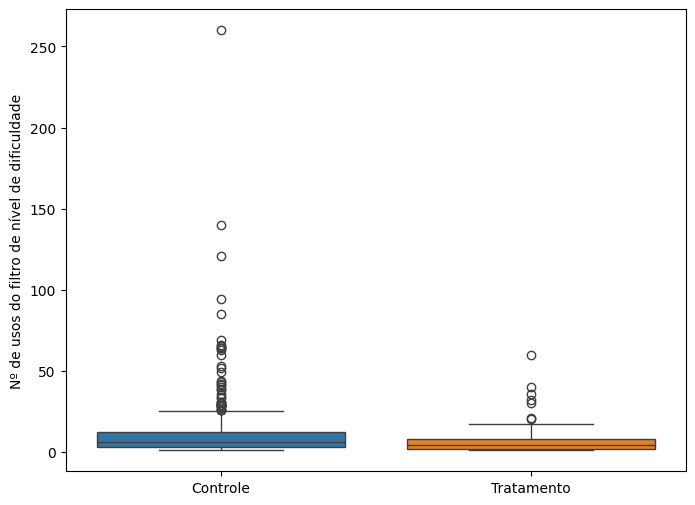

In [51]:
ct_filter_uses = []
ct_acts_created = []
ct_exs_selected = []

trt_filter_uses = []
trt_acts_created = []
trt_exs_selected = []

for group in final_metrics_for_each_user.keys():
    for user_id in final_metrics_for_each_user[group]:
        metrics = final_metrics_for_each_user[group][user_id]

        if group == "control":
            ct_filter_uses.append(metrics["filter_uses"])
            ct_acts_created.append(metrics["activities_created"])
            ct_exs_selected.append(metrics["exercises_selected"])

        if group == "treatment":
            trt_filter_uses.append(metrics["filter_uses"])
            trt_acts_created.append(metrics["activities_created"])
            trt_exs_selected.append(metrics["exercises_selected"])

ct_filters_df = pd.DataFrame(ct_filter_uses)
ct_acts_df = pd.DataFrame(ct_acts_created)
ct_exs_df = pd.DataFrame(ct_exs_selected)

trt_filters_df = pd.DataFrame(trt_filter_uses)
trt_acts_df = pd.DataFrame(trt_acts_created)
trt_exs_df = pd.DataFrame(trt_exs_selected)

filters_boxplot = pd.concat([ct_filters_df[0], trt_filters_df[0]], axis=1)
filters_boxplot.columns = ['Controle', 'Tratamento']

plt.figure(figsize=(8, 6))
sns.boxplot(data=filters_boxplot)
plt.title('')
plt.ylabel('Nº de usos do filtro de nível de dificuldade')
plt.show()

In [52]:
ct_filters_df.describe().round(2)

,0
count,429.00
mean,11.34
std,19.42
min,1.00
25%,3.00
50%,6.00
75%,12.00
max,260.00


In [53]:
trt_filters_df.describe().round(2)

,0
count,88.00
mean,7.58
std,9.44
min,1.00
25%,2.00
50%,4.50
75%,8.25
max,60.00


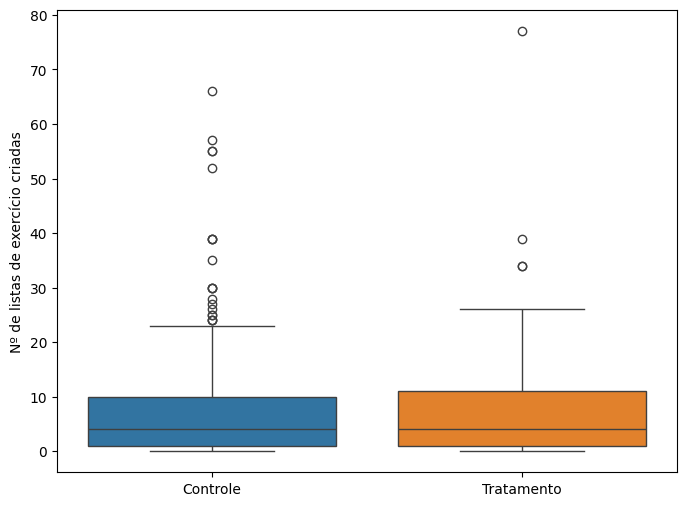

In [54]:
acts_boxplot = pd.concat([ct_acts_df[0], trt_acts_df[0]], axis=1)
acts_boxplot.columns = ['Controle', 'Tratamento']

plt.figure(figsize=(8, 6))
sns.boxplot(data=acts_boxplot)
plt.title('')
plt.ylabel('Nº de listas de exercício criadas')
plt.show()

In [55]:
ct_acts_df.describe().round(2)

,0
count,429.00
mean,7.41
std,9.09
min,0.00
25%,1.00
50%,4.00
75%,10.00
max,66.00


In [56]:
trt_acts_df.describe().round(2)

,0
count,88.00
mean,7.92
std,11.21
min,0.00
25%,1.00
50%,4.00
75%,11.00
max,77.00


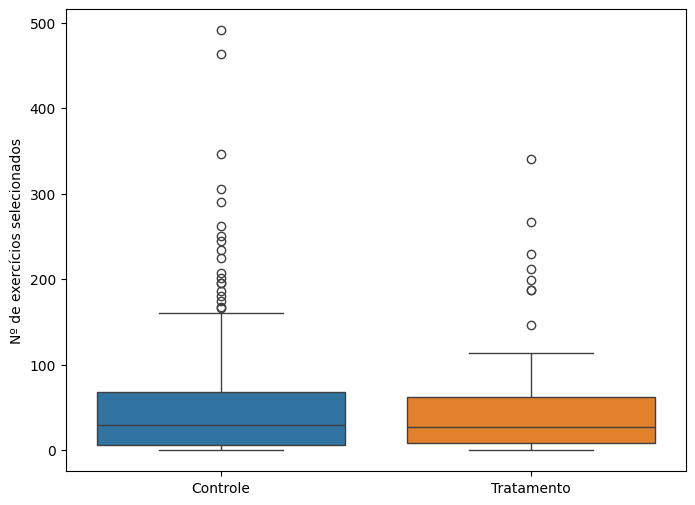

In [57]:
exs_boxplot = pd.concat([ct_exs_df[0], trt_exs_df[0]], axis=1)
exs_boxplot.columns = ['Controle', 'Tratamento']

plt.figure(figsize=(8, 6))
sns.boxplot(data=exs_boxplot)
plt.title('')
plt.ylabel('Nº de exercícios selecionados')
plt.show()

In [58]:
ct_exs_df.describe().round(2)

,0
count,429.00
mean,48.10
std,61.61
min,0.00
25%,6.00
50%,30.00
75%,68.00
max,491.00


In [59]:
trt_exs_df.describe().round(2)

,0
count,88.00
mean,48.83
std,64.30
min,0.00
25%,8.75
50%,27.50
75%,62.25
max,340.00


### Remove Outliers e Revisa Medidas de Tendência Central

Remoção de outliers pelo método de máximo e mínimo

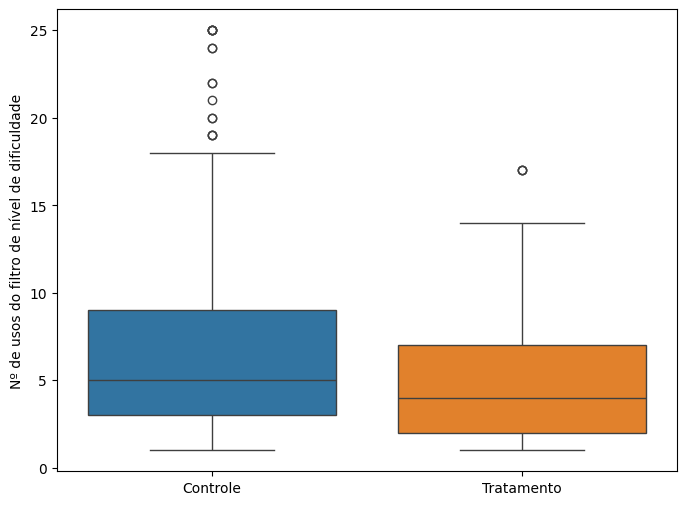

In [60]:
def remove_outliers_single_df(df, metric):
    Q1 = df[metric].quantile(0.25)
    Q3 = df[metric].quantile(0.75)
    IQR = Q3 - Q1
    bot_threshold = Q1 - 1.5 * IQR
    top_threshold = Q3 + 1.5 * IQR
    return df[(df[metric] >= bot_threshold) & (df[metric] <= top_threshold)]

ct_filters_df = remove_outliers_single_df(ct_filters_df, 0)
trt_filters_df = remove_outliers_single_df(trt_filters_df, 0)

filters_boxplot = pd.concat([ct_filters_df[0], trt_filters_df[0]], axis=1)
filters_boxplot.columns = ['Controle', 'Tratamento']

plt.figure(figsize=(8, 6))
sns.boxplot(data=filters_boxplot)
plt.title('')
plt.ylabel('Nº de usos do filtro de nível de dificuldade')
plt.show()

In [61]:
ct_filters_df.describe().round(2)

,0
count,386.00
mean,6.80
std,5.28
min,1.00
25%,3.00
50%,5.00
75%,9.00
max,25.00


In [62]:
trt_filters_df.describe().round(2)

,0
count,81.00
mean,5.28
std,4.02
min,1.00
25%,2.00
50%,4.00
75%,7.00
max,17.00


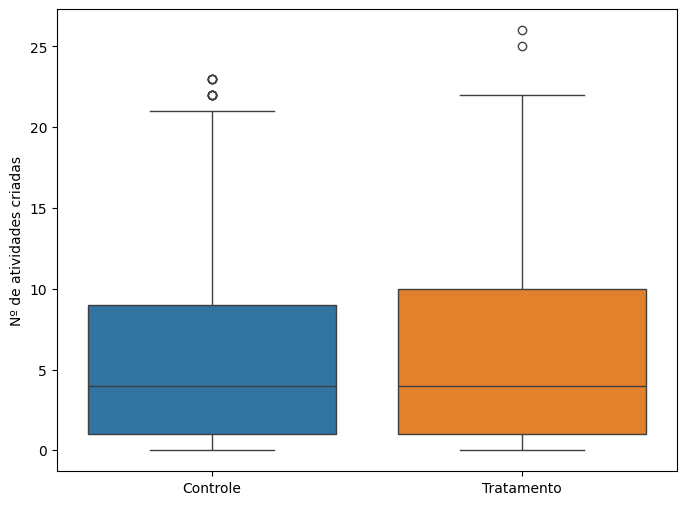

In [63]:
ct_acts_df = remove_outliers_single_df(ct_acts_df, 0)
trt_acts_df = remove_outliers_single_df(trt_acts_df, 0)

acts_boxplot = pd.concat([ct_acts_df[0], trt_acts_df[0]], axis=1)
acts_boxplot.columns = ['Controle', 'Tratamento']

plt.figure(figsize=(8, 6))
sns.boxplot(data=acts_boxplot)
plt.title('')
plt.ylabel('Nº de atividades criadas')
plt.show()

In [64]:
ct_acts_df.describe().round(2)

,0
count,409.00
mean,5.99
std,5.90
min,0.00
25%,1.00
50%,4.00
75%,9.00
max,23.00


In [65]:
trt_acts_df.describe().round(2)

,0
count,84.00
mean,6.11
std,6.55
min,0.00
25%,1.00
50%,4.00
75%,10.00
max,26.00


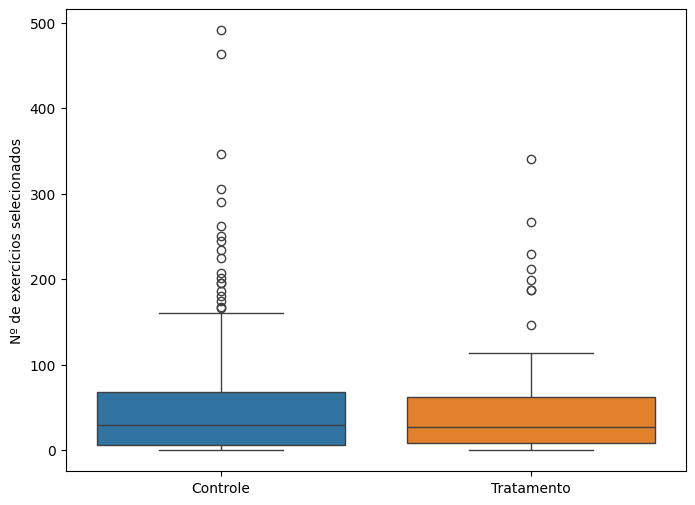

In [66]:
ct_exs_df = remove_outliers_single_df(ct_exs_df, 0)
trt_exs_df = remove_outliers_single_df(trt_exs_df, 0)

acts_boxplot = pd.concat([ct_exs_df[0], trt_exs_df[0]], axis=1)
acts_boxplot.columns = ['Controle', 'Tratamento']

plt.figure(figsize=(8, 6))
sns.boxplot(data=exs_boxplot)
plt.title('')
plt.ylabel('Nº de exercícios selecionados')
plt.show()

In [67]:
ct_exs_df.describe().round(2)

,0
count,410.00
mean,38.66
std,39.62
min,0.00
25%,5.00
50%,27.00
75%,61.75
max,161.00


In [68]:
trt_exs_df.describe().round(2)

,0
count,80.00
mean,31.61
std,30.64
min,0.00
25%,7.75
50%,22.50
75%,47.25
max,114.00


### Normalizando métricas

Atribuindo valores entre 0 e 1 para cada métrica através do método de máximo e mínimo após remover os pontos fora da curva através do método do intervalo interquartil.

In [69]:
all_filters = [*list(trt_filters_df[0]), *list(ct_filters_df[0])]
all_acts = [*list(trt_acts_df[0]), *list(ct_acts_df[0])]
all_exs = [*list(trt_exs_df[0]), *list(ct_exs_df[0])]
outlier_ids = []
not_outlier_ids = []

for group in final_metrics_for_each_user.keys():
    for user_id in final_metrics_for_each_user[group]:
        metrics = final_metrics_for_each_user[group][user_id]

        if metrics['filter_uses'] not in all_filters:
            outlier_ids.append(user_id)
            continue
            
        if metrics['activities_created'] not in all_acts:
            outlier_ids.append(user_id)
            continue
            
        if metrics['exercises_selected'] not in all_exs:
            outlier_ids.append(user_id)
            continue
            
        not_outlier_ids.append(outlier_ids)
        
all_metrics_dict = {
    'filter_uses': all_filters,
    'activities_created': all_acts,
    'exercises_selected': all_exs,
}

print('Removidos', len(outlier_ids), 'outliers, restam', len(not_outlier_ids), 'docentes')

Removidos 78 outliers, restam 439 docentes


In [70]:
print(stats.skew(ct_filters_df))
print(stats.skew(trt_filters_df))
print(stats.skew(ct_acts_df))
print(stats.skew(trt_acts_df))
print(stats.skew(ct_exs_df))
print(stats.skew(trt_exs_df))

[1.27746757]
[1.24469608]
[1.01080017]
[1.24074454]
[1.07962794]
[0.94922822]


In [71]:
import numpy as np

def normalize_metrics(data, all_metrics_dict):
    """
    Normaliza todas as métricas numéricas do dicionário para o intervalo [0,1] usando a normalização Min-Max.

    Parâmetros:
    - data (dict): Dicionário onde as chaves são IDs e os valores são dicionários com métricas.
    - all_metrics_dict (dict): Dicionário contendo todas as métricas para referência de normalização.

    Retorno:
    - dict: Novo dicionário com as métricas normalizadas.
    """
    normalized_data = data.copy()
    
    for user_id in normalized_data.keys():
        if user_id in outlier_ids:
            continue

        for metric_key in ['activities_created', 'exercises_selected', 'filter_uses']:
            all_values = np.array(all_metrics_dict[metric_key])
            
            # Normalização Min-Max
            min_val = np.min(all_values)
            max_val = np.max(all_values)
            
            if max_val == min_val:  # Evita divisão por zero
                normalized_value = 0.5  # Define um valor padrão caso não haja variação
            else:
                normalized_value = (normalized_data[user_id][metric_key] - min_val) / (max_val - min_val)
            
            normalized_data[user_id][f"normalized_{metric_key}"] = normalized_value
    
    return normalized_data

normalized_values = normalize_metrics(
    {**final_metrics_for_each_user['control'], **final_metrics_for_each_user['treatment']},
    all_metrics_dict
)

print('Valores normalizados com sucesso')

Valores normalizados com sucesso


### Criando tabelas de pesos AHP e calculando escore de qualidade

Defininindo tabela AHP conforme opinião dos envolvidos no experimento e aplicando pesos para calcular indicador único de qualidade.

In [72]:
fuzzy_scale = {
    "igualmente_importante": (1, 1, 1),
    "pouco_mais_importante": (1, 2, 3),
    "moderadamente_mais_importante": (4, 5, 6),
    "muito_mais_importante": (7, 8, 9),
    "extremamente_mais_importante": (9, 9, 9),
}

def apply_certainty(triangle, certainty="default"):
    sigma = 0.5

    if certainty == "high":
        sigma = 0.1
    elif certainty == "low":
        sigma = 0.9
    
    l, m, u = triangle

    return (m - sigma, m, m + sigma)

def deffuzzify(triangle):
    l, m, u = triangle;
    return (l + m + u) / 3


# não é necessária matriz de comparação para satisfação,
# já que é representada só por uma medida
# satisfaction_comparisons = {'filter_uses'}

# já a eficácia precisa de tabela de comparação
# para agregarmos as duas medidas que a representam
effectiveness_comparisons = {
    ("activities_created", "exercises_selected"): {
        "value": fuzzy_scale["muito_mais_importante"],
        "certainty": "default",
    },
}

# agregação das duas caracaterísticas
characteristics_comparison = {
    ("satisfaction", "effectiveness"): {
        "value": fuzzy_scale["moderadamente_mais_importante"],
        "certainty": "default",
    }
}

crisp_effectiveness_comparisons = {key: deffuzzify(apply_certainty(value["value"], value["certainty"])) for key, value in effectiveness_comparisons.items()}
crisp_characteristics_comparison = {key: deffuzzify(apply_certainty(value["value"], value["certainty"])) for key, value in characteristics_comparison.items()}


ahp_matrix_effectiveness = ahpy.Compare(
    "effectiveness",
    crisp_effectiveness_comparisons
)

ahp_matrix_characteristics = ahpy.Compare(
    "characteristics",
    crisp_characteristics_comparison
)



effectiveness_weights = ahp_matrix_effectiveness.target_weights
characteristics_weights = ahp_matrix_characteristics.target_weights
print("Pesos calculados para métricas de eficácia (n listas/n questões):\n", effectiveness_weights)
print("Pesos calculados para características (satisfação/eficácia):\n", characteristics_weights)


for user_id in normalized_values:
    metrics = normalized_values[user_id]
    
    if user_id in outlier_ids:
        continue

    effectiveness_score = (
        metrics['normalized_activities_created'] * effectiveness_weights.get('activities_created') +
        metrics['normalized_exercises_selected'] * effectiveness_weights.get('exercises_selected')
    )

    final_score = (
        metrics['normalized_filter_uses'] * characteristics_weights.get('satisfaction', 0) +
        effectiveness_score  * characteristics_weights.get('effectiveness', 0)
    )
    
    normalized_values[user_id]['final_score'] = final_score
    

scores_by_group = {"control": [], "treatment": []}
filter_uses_by_group = {"control": [], "treatment": []}
activities_created_by_group = {"control": [], "treatment": []}
exercises_selected_by_group = {"control": [], "treatment": []}


for user_id, metrics in normalized_values.items():
    if user_id in outlier_ids:
        continue

    group = metrics['group']
    user_score = metrics['final_score']
    user_filter_uses = metrics['normalized_filter_uses']
    user_activities_created = metrics['normalized_activities_created']
    user_exercises_selected = metrics['normalized_exercises_selected']
    
    scores_by_group[group].append(user_score)
    activities_created_by_group[group].append(user_activities_created)
    exercises_selected_by_group[group].append(user_exercises_selected)
    filter_uses_by_group[group].append(user_filter_uses)
    
    
print(f"\nIndicador calculado para cada usuário único.")
print(len(scores_by_group["control"]) + len(scores_by_group["treatment"]), f"usuários separados em grupos.")
print("Docentes do grupo de controle:", len(scores_by_group["control"]))
print("Docentes do grupo de tratamento:", len(scores_by_group["treatment"]))

Pesos calculados para métricas de eficácia (n listas/n questões):
 {'activities_created': 0.8889, 'exercises_selected': 0.1111}
Pesos calculados para características (satisfação/eficácia):
 {'satisfaction': 0.8333, 'effectiveness': 0.1667}

Indicador calculado para cada usuário único.
439 usuários separados em grupos.
Docentes do grupo de controle: 363
Docentes do grupo de tratamento: 76


### Verificando a distribuição dos escores e testando a diferença entre os grupos

A normalidade das distribuições é testada para definir qual teste de hipótese será aplicado

controle: distribuição não normal [8.89644853e-17]
tratamento: distribuição não normal [5.85197991e-06]


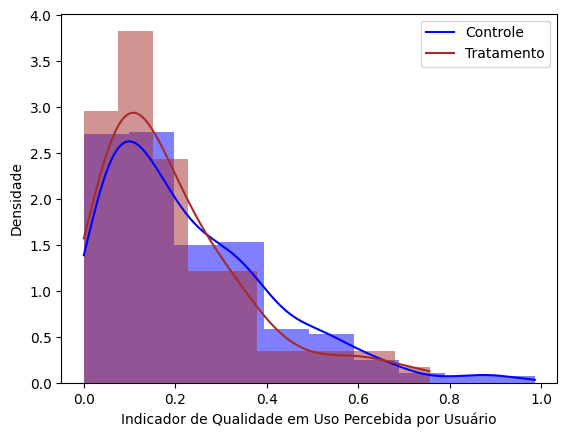

In [88]:
ct_scores_df = pd.DataFrame(scores_by_group["control"])
trt_scores_df = pd.DataFrame(scores_by_group["treatment"])

# ----------- TESTES DE NORMALIDADE -------------

scores_ct_stat, scores_ct_p_value = stats.normaltest(ct_scores_df)
scores_trt_stat, scores_trt_p_value = stats.normaltest(trt_scores_df)

if scores_ct_p_value > 0.05:
    print("controle: distribuição normal", scores_ct_p_value)
else:
    print("controle: distribuição não normal", scores_ct_p_value)

if scores_trt_p_value > 0.05:
    print("tratamento: distribuição normal", scores_trt_p_value)
else:
    print("tratamento: distribuição não normal", scores_trt_p_value)
    
# ------------------------------------------------


sns.histplot(ct_scores_df[0], kde=True, color='blue', label='', bins=10, stat='density', linewidth=0)
sns.histplot(trt_scores_df[0], kde=True, color='brown', label='', bins=10, stat='density', linewidth=0)

plt.title('')
plt.ylabel('Densidade')
plt.xlabel('Indicador de Qualidade em Uso Percebida por Usuário')
plt.legend(['Controle', 'Tratamento'])

plt.show()

In [74]:
ct_scores_df.describe().round(2)

,0
count,363.00
mean,0.23
std,0.19
min,0.00
25%,0.09
50%,0.18
75%,0.33
max,0.99


In [75]:
trt_scores_df.describe().round(2)

,0
count,76.00
mean,0.20
std,0.16
min,0.00
25%,0.08
50%,0.15
75%,0.28
max,0.76


In [76]:
scores_u_stat, scores_up_value = stats.mannwhitneyu(
    ct_scores_df[0], 
    trt_scores_df[0],
)

print(f"Estatística U: {scores_u_stat:.4f} p-valor: {scores_up_value:.8f}\n") 

alpha = 0.05

if scores_up_value < alpha:
    print("Há uma diferença estatística significativa entre os indicadores dos usuários de cada grupos.")
else:
    print("Não foi encontrada diferença estatística significativa entre os indicadores dos usuários de cada grupos.")
    


Estatística U: 15183.0000 p-valor: 0.16739137

Não foi encontrada diferença estatística significativa entre os indicadores dos usuários de cada grupos.


<Axes: >

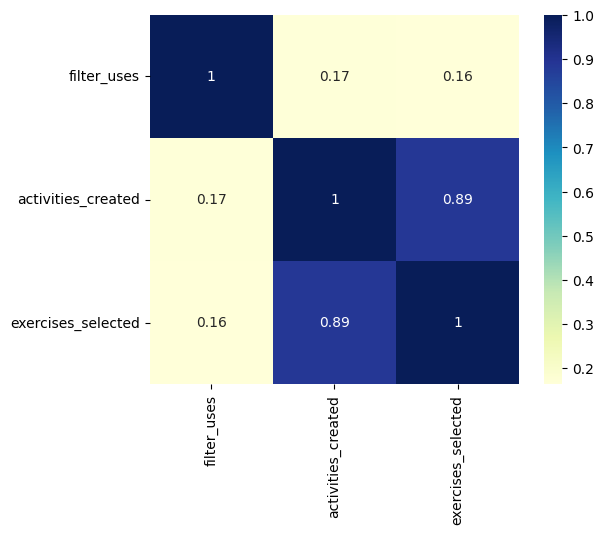

In [77]:
all_metrics_df = pd.DataFrame({
    'filter_uses': filter_uses_by_group["control"] + filter_uses_by_group["treatment"],
    'activities_created': activities_created_by_group["control"] + activities_created_by_group["treatment"],
    'exercises_selected': exercises_selected_by_group["control"] + exercises_selected_by_group["treatment"],
}) 

corr = all_metrics_df.corr(method='spearman')

corr.style.background_gradient(cmap='YlGnBu', axis=None)

sns.heatmap(corr, cmap="YlGnBu", annot=True, square=True)

### Verificando a adoção do filtro nos dois grupos

Comparação de proporção de adoção utilizando o teste chi-quadrado.

In [78]:
def get_users_adoption_by_group(events, filter_type):
    data_by_user_id = {};

    for event in events:
        user_id = event["properties"].get("$user_id")

        if not user_id:
            continue

        user_data = data_by_user_id.get(user_id)

        if not user_data:
            data_by_user_id[user_id] = event["properties"]["Used Filter"] == filter_type
            
            
    data = []
            
    for user_id in data_by_user_id.keys():
        data.append({
            "group": "treatment" if user_id in beta_testers_ids else "control",
            "adopted": data_by_user_id[user_id]
        })
        
    return data

adoption_df = pd.DataFrame(get_users_adoption_by_group(filters_results, "Nível de dificuldade"))

adopt_contingency = pd.crosstab(adoption_df['group'], adoption_df['adopted'])

print(adopt_contingency)

adopt_chi2, adopt_p_value, adopt_dof, adopt_expected = stats.chi2_contingency(adopt_contingency)

print(f"\nchi-quadrado: {adopt_chi2}")
print(f"p-valor: {adopt_p_value}")
print(f"graus de liberdade: {adopt_dof}")
print(f"frequências esperadas: {adopt_expected}")

alpha = 0.05

if adopt_p_value < alpha:
    print(f"\nHá uma diferença significativa na adoção do filtro de nível de dificuldade pelos grupos.")
else:
    print(f"\nNão há diferença significativa na adoção do filtro entre os grupos.")

adopted    False  True 
group                  
control     2567    429
treatment    420     88

chi-quadrado: 2.8815569608999345
p-valor: 0.08959934958168123
graus de liberdade: 1
frequências esperadas: [[2553.95319635  442.04680365]
 [ 433.04680365   74.95319635]]

Não há diferença significativa na adoção do filtro entre os grupos.


### Verificando a adoção do filtro de FONTE nos dois grupos

Comparação de proporção de adoção do filtro de FONTE utilizando o teste chi-quadrado. O filtro de fonte se tornou o último filtro, ocupando o lugar antigo do de nível de dificuldade na versão de tratamento

In [79]:
adoption_fonte_df = pd.DataFrame(get_users_adoption_by_group(filters_results, "Fonte"))

adopt_fonte_contingency = pd.crosstab(adoption_fonte_df['group'], adoption_fonte_df['adopted'])

print(adopt_fonte_contingency)

adopt_fonte_chi2, adopt_fonte_p_value, adopt_fonte_dof, adopt_fonte_expected = stats.chi2_contingency(adopt_fonte_contingency)

print(f"\nchi-quadrado: {adopt_fonte_chi2}")
print(f"p-valor: {adopt_fonte_p_value}")
print(f"graus de liberdade: {adopt_fonte_dof}")
print(f"frequências esperadas: {adopt_fonte_expected}")

alpha = 0.05

if adopt_fonte_p_value < alpha:
    print(f"\nHá uma diferença significativa na adoção do filtro de fonte pelos grupos.")
else:
    print(f"\nNão há diferença significativa na adoção do filtro de fonte entre os grupos.")

adopted    False  True 
group                  
control     2843    153
treatment    464     44

chi-quadrado: 9.684079422642995
p-valor: 0.0018587148982089575
graus de liberdade: 1
frequências esperadas: [[2827.56050228  168.43949772]
 [ 479.43949772   28.56050228]]

Há uma diferença significativa na adoção do filtro de fonte pelos grupos.


### Verificando a proporção do uso do filtro quando comparado a outras categorias

Verificando se proporcionalmente o uso do filtro de nível de dificuldade é diferente entre os grupos

In [80]:
def get_users_proportion_by_group(events, used_filter):
    data_by_user_id = {};

    for event in events:
        user_id = event["properties"].get("$user_id")

        if not user_id:
            continue

        user_data = data_by_user_id.get(user_id)
        
        if not user_data:
            data_by_user_id[user_id] = {
                "difficulty": 0,
                "outro": 0,
            }
        
        is_by_difficulty = event["properties"]["Used Filter"] == used_filter

        
        if is_by_difficulty:
            data_by_user_id[user_id]['difficulty'] += 1
        else:
            data_by_user_id[user_id]['outro'] += 1
            
            
    data = {
        "control": [],
        "treatment": [],
    }
            
    for user_id in data_by_user_id.keys():
        group = "treatment" if user_id in beta_testers_ids else "control"
        outro = data_by_user_id[user_id]['outro']
        difficulty = data_by_user_id[user_id]['difficulty']
        total = outro + difficulty
        if difficulty == 0:
            continue
        data[group].append(difficulty / total)
        
    return data

proportion_data = get_users_proportion_by_group(filters_results, "Nível de dificuldade")
ct_proportion_df = pd.DataFrame(proportion_data["control"])
trt_proportion_df = pd.DataFrame(proportion_data["treatment"])### Verificando a adoção do filtro nos dois grupos

# Comparação de proporção de adoção utilizando o teste chi-quadrado.

ct_proportion_df.describe().round(2)

,0
count,429.00
mean,0.28
std,0.21
min,0.01
25%,0.11
50%,0.24
75%,0.38
max,1.00


In [81]:
trt_proportion_df.describe().round(2)

,0
count,88.00
mean,0.29
std,0.24
min,0.01
25%,0.12
50%,0.22
75%,0.40
max,1.00


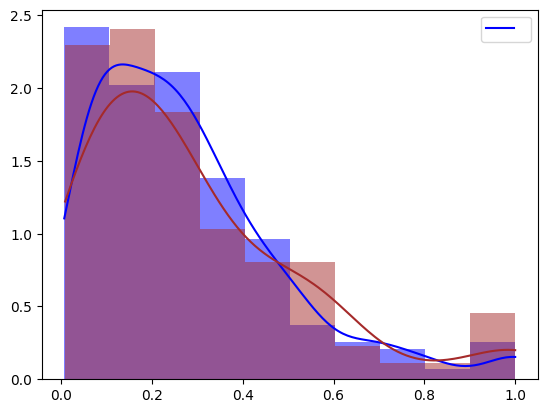

In [82]:
sns.histplot(ct_proportion_df[0], kde=True, color='blue', label='', bins=10, stat='density', linewidth=0)
sns.histplot(trt_proportion_df[0], kde=True, color='brown', label='', bins=10, stat='density', linewidth=0)

plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.legend([''])

plt.show()

In [83]:
prop_u_stat, prop_up_value = stats.mannwhitneyu(
    ct_proportion_df[0], 
    trt_proportion_df[0],
)

print(f"Estatística U: {prop_u_stat:.4f} p-valor: {prop_up_value:.8f}\n") 

alpha = 0.05

if prop_up_value < alpha:
    print("Há uma diferença estatística significativa entre a proporção nas categorias utilizadas pelos usuários de cada grupo.")
else:
    print("Não foi encontrada diferença estatística significativa entre a proporção nas categorias utilizadas pelos usuários de cada grupo.")

Estatística U: 19109.5000 p-valor: 0.85516348

Não foi encontrada diferença estatística significativa entre a proporção nas categorias utilizadas pelos usuários de cada grupo.
